# Lesson_5. Decisions trees.

# Решающие деревья

In [58]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, plot_roc_curve, plot_confusion_matrix, \
    plot_precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9, 6)})

Сначала рассмотрим пример, а для этого создадим датафрейм:

In [59]:
df = pd.DataFrame({
    'X_1': [1, 1, 1, 0, 0, 0, 0, 1],
    'X_2': [0, 0, 0, 1, 0, 0, 0, 1],
    'Y': [1, 1, 1, 1, 0, 0, 0, 0]
})
df

,X_1,X_2,Y
0,1,0,1
1,1,0,1
2,1,0,1
3,0,1,1
4,0,0,0
5,0,0,0
6,0,0,0
7,1,1,0


Создадим решающее дерево: (посадим его, в качестве критерия будем использовать энтропию)

In [60]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf

DecisionTreeClassifier(criterion='entropy')

Теперь отдельно возьмем датафрейм с фичами и отдельно возьмем зависимую переменную (она имеет вид серии)

In [61]:
# В икс помещаем фичи:
X = df[['X_1', 'X_2']]

# В игрек помещаем поле, которое предсказываем:
y = df.Y

In [62]:
# Обучаем модель:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

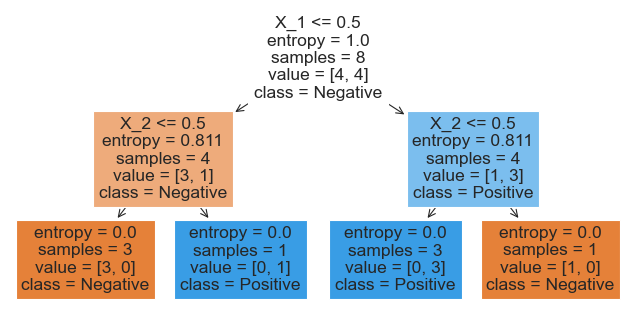

In [63]:
# Визуализируем решающее дерево:
plt.figure(figsize=(10, 5), dpi=80)
tree.plot_tree(clf, feature_names=X.columns, class_names=['Negative', 'Positive'], filled=True);

# аргументы - имена фичей, имена классов (они соответствуют значениям 0 и 1 зависимой переменной), заполнение

## Титаник

Теперь поработаем с датасетом Титаник, который легко можно найти на Kaggle.
Основная задача - выбрать фичи, которые будут предсказывать выжил человек или нет (Survived). Затем обучим модель и посмотрим, насколько хорошо она предсказывает:)

In [64]:
df = pd.read_csv('train.csv')

Как обычно сначала посмотрим на структуру наших данных:

In [65]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Легко видеть, что в поле Cabin есть пропущенные значение (NaN), а давайте посмотрим, есть ли они где - то еще:

In [66]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

В итоге видим, сколько пропущенных значений в каждой колонке.

Так как мы хотим сейчас найти фичи, которые будем использовать для предсказания переменной Survived, то логично было бы исключить поле Cabin, ведь там пропущенных значений очень много. Исключим также переменную Survived (ведь мы ее будем предсказывать, она уйдет в $y$). А также исключим PassengerId, Name и Ticket, так как никакой информативности они нести не будут.

In [67]:
X = df.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [68]:
y = df.Survived

Дерево решений умеет работать только с числовыми переменными. Поэтому преобразуем сразу нечисловые переменные в числовой вид, это легко кодируется нулями и единицами. В пандасе есть хорошая функция `pd.get_dummies()`, принимающая своим аргументом датафрейм. Она реализует требуемую задачу.

In [69]:
X = pd.get_dummies(X)
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


Также отметим, что дерево решений не умеет работать с пропущенными значениями. Поэтому заполним их (для простоты) медианным возрастом всех людей, у которых возраст известен, конечно. 

`X.fillna({'name_column': 'value'})` легко справляется с этим. Достаточно в словарь по ключу передать столбец (столбцы), в которых хотим заменить пропущенные значения, и значение (значения), которыми заменим эти пропущенные значения.

In [70]:
X = X.fillna({'Age': X.Age.median()})

In [71]:
X.isnull().sum() # Как мы видим, теперь пропущенных значений нет.

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

## Тренировочная и тестовая выборки

Давайте заного построим модель, но с конкретным random_state. Random_state - это рандомный сид, здесь выберем 42, как у Толи.

In [72]:
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
clf

DecisionTreeClassifier(criterion='entropy', random_state=42)

Итак, разобьем теперь наши данные на тренировочные и тестовые. Мы возьмем 33 процента случайных строк в таблице $X$ и 33 процента случайных элементов серии $y$, это и будут наши тестовые данные. На остальных 67 процентах мы будем тренироваться.

`train_test_split('дата с фичами', 'переменная, которую предсказываем', 'доля тестовой выборки', 'рандомный сид')` реализует это и возвращает 4 обьекта в виде:
```
X_train, X_test, y_train, y_test
```

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [74]:
X_train.shape

(596, 10)

In [75]:
X_test.shape

(295, 10)

Обучим теперь модель на тренировочных данных:

In [76]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

Метод `.score()` отлично справляется с этим.

In [77]:
clf.score(X_train, y_train)

0.9798657718120806

Естественный вопрос, а почему мы обучали модель (дерево) на данных X_train, y_train, а в итоге эта модель предсказывает y_train по данным X_train не с вероятностью 1?

Это происходит, так как мы выкинули некоторые переменные из данных, поэтому у нас могут в данных X_train полностью совпасть строки, но значения y_train отличаться. А значит, мы не сможем отнести эти оба наблюдения к какому - то классу. Т.е нарушается однозначность. Отсюда также следует, что где - то энтропия не будет равна нулю в конце ветки.

Итак, теперь посмотрим, как хорошо наша модель предсказывает, выжил ли пассажир или нет, на тестовых данных.

In [78]:
clf.score(X_test, y_test)

0.7762711864406779

Разница в скорах большая, что - то не так, скорее всего, модель переобучена. Т.е мы просто очень сильно подогнали ее под тренировочную выборку. Это ведь же не значит, что на тестовой она поведет себя так же хорошо.

## Глубина дерева

`tree.DecisionTreeClassifier()` принимает еще один аргумент - это глубина дерева. Зададим ее сейчас равной 5 и посмотрим, что происходит.

In [79]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

Обучим модель снова на тренировочной выборке.

In [80]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

In [81]:
clf.score(X_train, y_train)

0.8406040268456376

Результат стал хуже на тренировочной выборке, так будет всегда при уменьшении глубины дерева, ведь это монотонная функция:)

In [82]:
clf.score(X_test, y_test)

0.8067796610169492

А на тестовой выборке у нас совпадений аж 80 процентов, это больше, чем было. Хотя глубина меньше. Это и значит, что наша модель была переучена.

Выясним, как ведут себя значения скоров для трейна и теста при разной глубине дерева:

(здесь результат - суть отношение правильно угаданных значений survived к неправильным)

In [83]:
scores = pd.DataFrame()

for max_depth in range(1, 100):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth) # Создаем модель, где задаем глубину дерева
    clf.fit(X_train, y_train) # Обучаем эту модель на тренировочных данных
    train_score = clf.score(X_train, y_train) # Записываем результат для тренировочной выборки
    test_score = clf.score(X_test, y_test) # Записываем результат для тестовой выборки
    
    temp = pd.DataFrame({'max_depth': [max_depth], 'train_score': [train_score], 'test_score': [test_score]})
    scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score

scores.head()

C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The fram

C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The fram

C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The fram

C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp) # Заносим в датафрейм глубину дерева, а также train_score и test_score
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\2486972115.py:10: FutureWarning: The fram

,max_depth,train_score,test_score
0,1,0.781879,0.796610
0,2,0.805369,0.776271
0,3,0.823826,0.820339
0,4,0.833893,0.823729
0,5,0.840604,0.806780


Приведем это к более удобному виду:)

In [84]:
scores = pd.melt(
    scores,
    id_vars=['max_depth'],
    value_vars=['train_score', 'test_score'],
    var_name='type',
    value_name='score'
)
scores.head()

,max_depth,type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


А теперь визуализируем, как train_score и test_score зависят от глубины дерева:

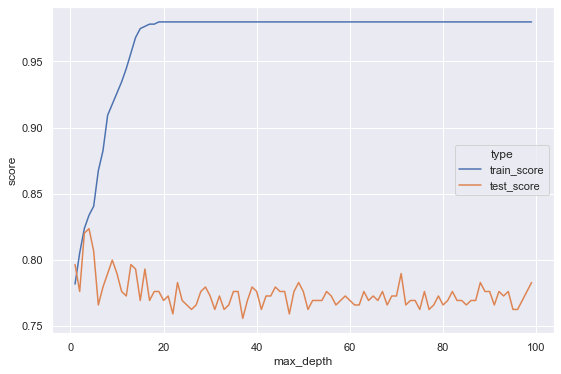

In [85]:
sns.lineplot(x='max_depth', y='score', hue='type', data=scores);

При глубине дерева равной 4 - ем достигается максимум по переменной test_score:

In [86]:
scores.loc[scores.score == scores[scores.type == 'test_score'].score.max()]

,max_depth,type,score
102,4,test_score,0.823729


Итак, наша модель все равно переобучена, а почему?

Как я понял, у нас есть данные на титанике. Мы хотим построить древовидную модель, а именно, построить такое дерево, чтобы в дальнейшем по нему предсказывать зависимую переменную. 

Что мы делали ранее?

Предлагалось генерить **одну test и одну train выборку** и в этом и заключалась основная проблема. Ведь мы для каждого k проверяли test выборку на модели, обученной на train выборке с глубиной дерева равной k, а затем выбирали такое k, что test_score максимален. Тем самым мы **подгоняем** параметр глубины дерева модели с **помощью какой - то одной выборки**. А это не суть того, что мы хотим.

Кажется, что было бы лучше генерить **много test и train выборок**, для каждых из них проделывать то, что мы делали раньше, а затем анализировать уже этот результат. Например, можно усреднить (или взять медиану значений) train score при каждом значении глубины и также взять среднее (или взять медиану значений) test score при каждом значении глубины. Затем визуализировать это.

Все - таки с помощью этого подхода будет более логичнее распространять наши предположения на всю ген. совокупность.

## Кроссвалидация

Здесь можно почитать подробней про это:

[Crossvalidation](https://scikit-learn.org/stable/modules/cross_validation.html)

Рассмотрим на примере, когда глубина дерева равна 4-ем:

In [87]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

Функция `cross_val_score()` отлично справляется с тем, что написано в статье выше:

In [88]:
cross_val_score(clf, X_train, y_train, cv=5)
# 5 значений - это точность, которую показал классификатор, разбив X_train y_train на 5 равных кусочков
# сначала обучился на первых четырех и предсказал пятый
# потом обучился на всех, кроме 4-го и предсказал 4-й и т.д...

array([0.76666667, 0.82352941, 0.78991597, 0.75630252, 0.80672269])

In [89]:
# Получим среднюю точность на кроссвалидации:
cross_val_score(clf, X_train, y_train, cv=5).mean()

0.7886274509803922

Проделаем теперь аналогичную вещь, что делали до этого, только добавим еще сюда кроссвалидацию

In [90]:
scores = pd.DataFrame()

for max_depth in range(1, 100):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    temp = pd.DataFrame({
        'max_depth': [max_depth],
        'train_score': [train_score],
        'test_score': [test_score],
        'mean_cross_val_score': [mean_cross_val_score],
    })
    scores = scores.append(temp)

scores.head()

C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: Futu

C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: Futu

C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(temp)
C:\Users\csc20\AppData\Local\Temp\ipykernel_10124\3124733124.py:15: Futu

,max_depth,train_score,test_score,mean_cross_val_score
0,1,0.781879,0.796610,0.781961
0,2,0.805369,0.776271,0.770196
0,3,0.823826,0.820339,0.790322
0,4,0.833893,0.823729,0.788627
0,5,0.840604,0.806780,0.802073


In [91]:
scores = pd.melt(
    scores,
    id_vars=['max_depth'],
    value_vars=['train_score', 'test_score', 'mean_cross_val_score'],
    var_name='type',
    value_name='score'
)
scores.head()

,max_depth,type,score
0,1,train_score,0.781879
1,2,train_score,0.805369
2,3,train_score,0.823826
3,4,train_score,0.833893
4,5,train_score,0.840604


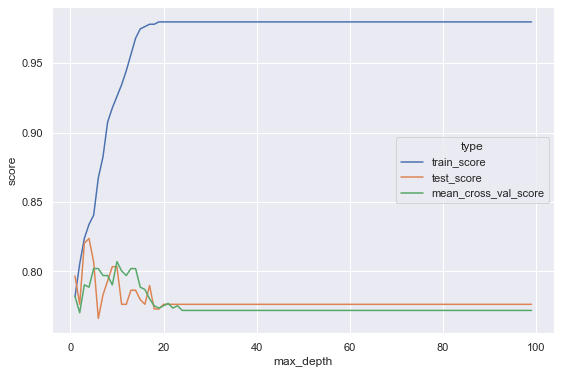

In [92]:
sns.lineplot(x='max_depth', y='score', hue='type', data=scores);

При глубине дерева равной 10 - ти достигается максимум по переменной mean_cross_val_score:

In [93]:
scores.loc[scores.score == scores[scores.type == 'mean_cross_val_score'].score.max()]

,max_depth,type,score
207,10,mean_cross_val_score,0.807073


In [94]:
# На основе этой глубины заводим бест классифаир:
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)

# Обучим его на тренировочных данных:
best_clf.fit(X_train, y_train)

# Протестируем точность (процент правильных ответов):
best_clf.score(X_test, y_test)

0.8033898305084746

## Точность

In [95]:
# Точность хорошо работает только на выборках, у которых целевая переменная сбалансирована.

# Здесь же присутствует дисбаланс классов.
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [41]:
df.Survived.mean()
# 38.3% выжили в выборке.

0.3838383838383838

In [96]:
df.Survived.value_counts()[0] / (df.Survived.value_counts()[0] + df.Survived.value_counts()[1])
# 61.6% не выжили в выборке.

0.6161616161616161

In [97]:
# Классификатор, который будет тупо классифицировать ЛЮБОГО пассажира, как невыжившего, достигнет точности 61.6%.

## Метрики качества

In [98]:
# Pr (precision) - метрика, где ложно-положительные срабатывания (ложная тревога) отрицательно повлияют на коэф.
# или так называемые ошибки первого рода.

# Предсказываем выживших на титанике (True Positive).
# Например, в тестовой выборке предсказываем, что 100 чел выжили.
# Но на самом деле из этих 100 человек не выжили 20 (False Positive), т.е. мы ошиблись в 20 случаях.
# Это негативно повлияет на precision:
# Pr = 80 / (80 + 20) = 0.8

$$ Pr = \frac{TP}{TP + FP} $$

In [99]:
# R (recall) - метрика, где ложно-отрицательные срабатывания (пропуск цели) отрицательно повлияют на коэф.
# или так называемые ошибки второго рода.

# Опять предсказываем выживших на титанике (True Positive).
# Например, в тестовой выборке предсказываем, что 100 чел выжили. И это на самом деле оказалось так.
# Но мы не смогли правильно определить еще 20 выживших и отнесли из к невыжившим (False Negative).
# Это негативно повлияет на recall:
# R = 100 / (100 + 20) = 0.83

\begin{equation}
R = \frac{TP}{TP + FN}
\end{equation}

In [100]:
# Recall    - показывает, насколько достигнута цель (какой процент выживших удалось обнаружить).
# Precision - какую цену в виде ложных срабатываний за это заплатили.

## Подбор параметров

In [101]:
# На практике подбор параметров дерева не пишут руками, а используют GridSearchCV.

# Понадобится классификатор:
clf = tree.DecisionTreeClassifier(random_state=0)
clf

DecisionTreeClassifier(random_state=0)

In [102]:
# Словарь с параметрами классификатора, комбинации которых мы будем подбирать и проверять на кроссвалидации:
params = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30)}

# И укажем 5 фолдов для кроссвалидации:
grid_search_cv_clf = GridSearchCV(clf, params, cv=5)

In [103]:
# Обучаем на тренировочных данных:
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [104]:
# Посмотрим параметры, для которых значение эккураси будет максимальным:
grid_search_cv_clf.best_params_

{'criterion': 'entropy', 'max_depth': 8}

In [105]:
# Получим лучший классификатор:
best_clf = grid_search_cv_clf.best_estimator_
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0)

In [106]:
best_clf.score(X_test, y_test)

0.7932203389830509

In [107]:
# Предскажем погибших и выживших:
y_pred = best_clf.predict(X_test)

In [108]:
# Precision:
precision_score(y_test, y_pred)

0.8041237113402062

In [109]:
# Recall:
recall_score(y_test, y_pred)

0.65

## Повышаем Precision - понижаем Recall, и наоборот

In [110]:
# Вероятность отнесения пассажира к тому или иному классу:
y_pred_prob = grid_search_cv_clf.predict_proba(X_test)
pd.DataFrame(y_pred_prob, columns=['Вероятность погибнуть', 'вероятность выжить']).head()

,Вероятность погибнуть,вероятность выжить
0,0.885246,0.114754
1,0.615385,0.384615
2,0.885246,0.114754
3,0.000000,1.000000
4,0.000000,1.000000


In [111]:
# По умолчанию вероятность отнесения к классу конвертируется по отсечке 0.5
y_pred

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0], dtype=int64)

In [112]:
# Отберем только вторую колонку, т.е. вероятность выжить:
pd.Series(y_pred_prob[:, 1]).head()

0    0.114754
1    0.384615
2    0.114754
3    1.000000
4    1.000000
dtype: float64

<AxesSubplot:>

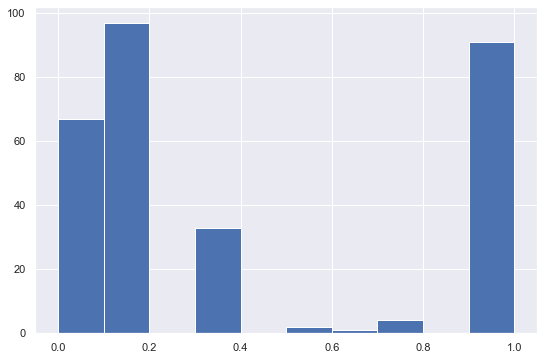

In [113]:
pd.Series(y_pred_prob[:, 1]).hist()

In [60]:
sorted(
    pd.Series(y_pred_prob[:, 1]).unique()
)

[0.0,
 0.05263157894736842,
 0.07692307692307693,
 0.10526315789473684,
 0.14418604651162792,
 0.3939393939393939,
 0.65625,
 0.8775510204081632,
 0.9852941176470589,
 1.0]

In [114]:
# Установим границу повыше на 0.8:
y_pred = np.where(y_pred_prob[:, 1] > 0.8, 1, 0)
y_pred

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0])

In [115]:
# Precision стал больше:
precision_score(y_test, y_pred)

0.8131868131868132

In [116]:
# Recall стал меньше:
recall_score(y_test, y_pred)

0.6166666666666667

In [117]:
# Установим границу пониже:
y_pred = np.where(y_pred_prob[:, 1] > 0.1, 1, 0)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1])

In [118]:
# Precision стал меньше:
precision_score(y_test, y_pred)

0.4692982456140351

In [119]:
# Recall стал больше:
recall_score(y_test, y_pred)

0.8916666666666667

C:\Users\csc20\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


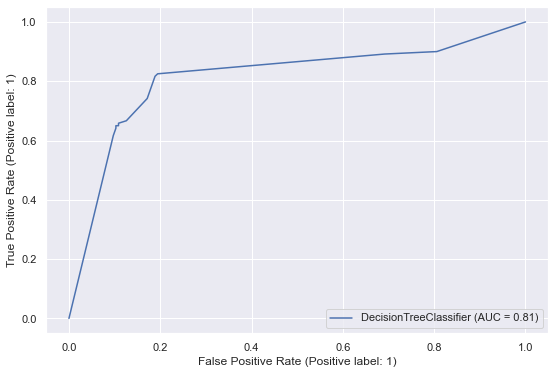

In [121]:
# Построим ROC-кривую:
plot_roc_curve(best_clf, X_test, y_test);

C:\Users\csc20\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


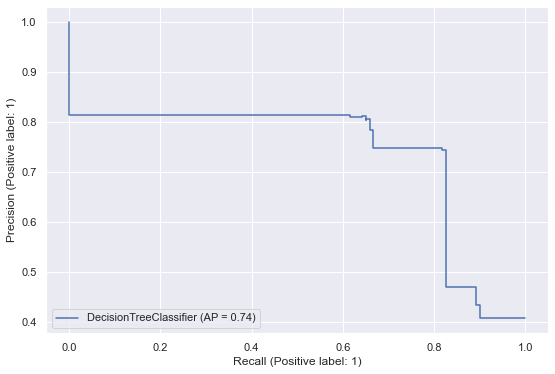

In [123]:
# Построим ROC-кривую по осям которой Precision и Recall:
plot_precision_recall_curve(best_clf, X_test, y_test);

C:\Users\csc20\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


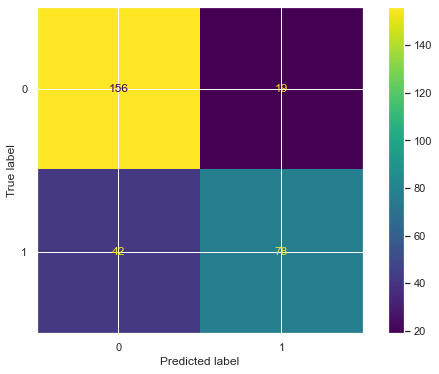

In [124]:
# Построим onfusion matrix:
plot_confusion_matrix(best_clf, X_test, y_test);